In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import multi_gpu_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from code.modelhelper import *

c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dty

In [2]:
N_VOCAB = 5000
N_CLASS = 2
BATCH_SIZE = 256
EPOCHS = 300

In [3]:
x = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11)

In [5]:
print(x.shape, y.shape)

(60000, 20) (60000, 2)


In [6]:
model_input = Input(shape=(x.shape[1], ), name="m3_input")
H = Embedding(N_VOCAB, 32, name="m3_embedding")(model_input)
H = SpatialDropout1D(0.25, name="m3_spacialdropout1d")(H)
H = LSTM(32, name="m3_lstm")(H)
model_output = Dense(N_CLASS, activation="softmax", name="m3_output")(H)

model = Model(model_input, model_output)
model.summary()

model = multi_gpu_model(model, gpus=2)

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m3_input (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
m3_embedding (Embedding)     (None, 20, 32)            160000    
_________________________________________________________________
m3_spacialdropout1d (Spatial (None, 20, 32)            0         
_________________________________________________________________
m3_lstm (LSTM)               (None, 32)                8320      
_________________________________________________________________
m3_output (Dense)            (None, 2)                 66        
Total params: 168,386
Trainable params: 168,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300


W0826 19:47:50.405298  8532 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


48000/48000 - 6s - loss: 0.2986 - accuracy: 0.8748 - val_loss: 0.1171 - val_accuracy: 0.9625
Epoch 2/300
48000/48000 - 2s - loss: 0.1033 - accuracy: 0.9655 - val_loss: 0.0965 - val_accuracy: 0.9678
Epoch 3/300
48000/48000 - 2s - loss: 0.0842 - accuracy: 0.9725 - val_loss: 0.0940 - val_accuracy: 0.9700
Epoch 4/300
48000/48000 - 2s - loss: 0.0769 - accuracy: 0.9752 - val_loss: 0.0905 - val_accuracy: 0.9694
Epoch 5/300
48000/48000 - 2s - loss: 0.0715 - accuracy: 0.9769 - val_loss: 0.0919 - val_accuracy: 0.9688
Epoch 6/300
48000/48000 - 2s - loss: 0.0688 - accuracy: 0.9773 - val_loss: 0.0927 - val_accuracy: 0.9686
Epoch 7/300
48000/48000 - 2s - loss: 0.0659 - accuracy: 0.9791 - val_loss: 0.0913 - val_accuracy: 0.9696
Epoch 8/300
48000/48000 - 2s - loss: 0.0642 - accuracy: 0.9793 - val_loss: 0.0929 - val_accuracy: 0.9697
Epoch 9/300
48000/48000 - 2s - loss: 0.0625 - accuracy: 0.9803 - val_loss: 0.0923 - val_accuracy: 0.9694
12000/1 [==========================================================

In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = to_bin(model.predict(x_test))
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.09052587586455046
Test accuracy: 0.9694167
Test recall: 0.9121324771882393
[[8934  107]
 [ 260 2699]]


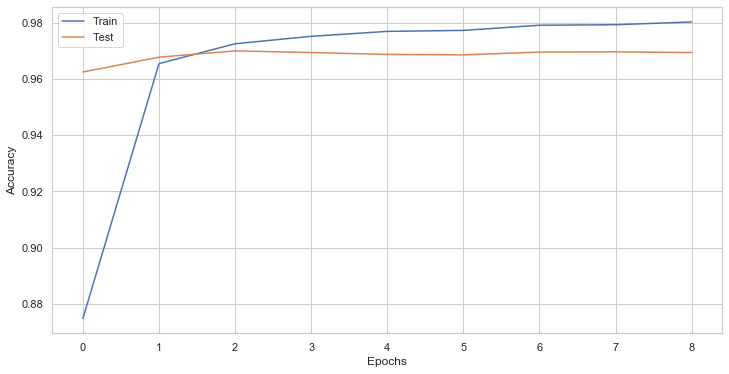

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# model.save("models/dl/m3.h5")